# An Exercise in Machine Learning
### Introduction
In the notebook below, you will find a rough outline guiding you through the process of creating, training, evaluating, and troubleshooting a Convolutional Neural Network. The principles you will learn herein are applicable to much more than the specific example shown here and will be useful if you ever come across machine learning in your future studies and work.

### The Dataset
The dataset you will be working with is called a [Minimalist Histopathology Image Dataset](https://bmirds.github.io/MHIST/) (MHIST). This dataset accomplishes a similar goal to MNIST, providing a rich, labeled dataset for training and testing models on medical image data. If you intend to play around with this dataset on your own, keep in mind the acceptable use policy on the website.

The dataset contains images of colon tissue, some from tissue diagnosed as a Hyperplastic Polyp (HP) - a benign growth - or as a Sessile Serrated Adenoma (SSA) - a malignant growth. Your task will be to create a machine learning model that learns the datast and can classify new data as HP or SSA.

The data itself is a set of images of the tissue samples, size 224x224x3 (ie RGB images). The images come with labels and the number of experts who voted that the sample was positive. The data is prelabeled in the included *annotations.csv* file as training or testing.

### Running the Notebook
Make sure to connect the runtime to a T4 GPU (where it says connect and/or shows your CPU/RAM usage at the top right). This will dramatically reduce the time it takes to run your model without any additional effort. **The runtimes may not be consistently available** subject to the whims of Google, so plan ahead and reach out if you cannot access one.

### Goal
The biggest goal of this assignment is to give you some experience with some common machine learning approaches and the necessary preprocessing steps to implement them. This dataset is extremely tricky given the power of the machines we have available for this task, so aim for an accuracy around 70%. **Any model which only predicts a single class is not an acceptable solution**. This is difficult to prevent entirely, however, so aim for a recall of > 0.4 (see model training section of notebook).

### Imports
The first section, shown below, is a cell for your import statements. **Not everything you will need to import is included here immediately**, but this should give you everything you need outside of building the model itself. If you find other useful functions, feel free to use them. It's general practice to include all import statements at the beginning, but some choose to import specialized functions only as needed.

To know what needs to be imported, reference the MNIST dataset example and the docs on the various [keras.layers](https://keras.io/api/layers/). The model should be constructed using Keras.

In [ ]:
### Imports
import numpy as np
np.random.seed(7)

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
# Add model-related imports here!

import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('./drive')
import cv2

Mounted at ./drive


### Data Loading
Your Google Drive will be mounted to ./drive. From here you can find the MHIST folder. In the folder, you will find a folder labeled "images" containing the images. You will also find a CSV labeled "annotations.csv." Explore these to familiarize yourself with how the data is formatted and labeled.

In particular, pay attention to what your classes should be. How many are there? What other information do we have?

To load the data, the first cell will mount your Google Drive to ./drive, so if you intend to work in Colab, your file path will look like './drive/MyDrive/path/to/file'

For this section, I recommend taking all the information you can from the CSV file rather than trying to do too much yourself. In particular, I recommend using [Pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide), starting with the line pd.read_csv('./drive/MyDrive/path/to/file'). If you're unfamiliar with Python, it's helpful to print out the pandas dataframe using print(dataframe) to make sure things are loading as you intend.

You may also want to use [cv2.resize()](https://www.geeksforgeeks.org/image-resizing-using-opencv-python/) to do testing with smaller images and less training time.

This might take a long time (like 20 minutes to an hour) as importing from Drive is really slow.

In [ ]:
### Data import

# Import metadata from annotations
metadata = pd.read_csv('./drive/My Drive/EE 5811 HW/MHIST/annotations.csv')

In [ ]:
from sklearn.model_selection import train_test_split

train_data = metadata[metadata['Partition'] == 'train']
test_data = metadata[metadata['Partition'] == 'test']

x_train_filenames = train_data['Image Name']
y_train_labels = train_data['Majority Vote Label']

X_test_filenames = test_data['Image Name']
y_test_labels = test_data['Majority Vote Label']

In [ ]:
height = width = 224

img_path = './drive/My Drive/EE 5811 HW/MHIST/images/images/'

x_train = []
for filename in x_train_filenames:
    img = load_img(img_path + filename, target_size=(height, width))  # Adjust target_size as needed
    img_array = img_to_array(img)
    x_train.append(img_array)

x_train = np.array(x_train) / 255.0  # Normalize pixel values

In [ ]:
# Load and preprocess the test images
x_test = []
for filename in X_test_filenames:
    img = load_img(img_path + filename, target_size=(height, width))
    img_array = img_to_array(img)
    x_test.append(img_array)

x_test = np.array(x_test) / 255.0  # Normalize pixel values

In [ ]:
from tensorflow.keras.utils import to_categorical

label_mapping = {'HP': 0, 'SSA': 1}
# Convert training set labels
y_train = y_train_labels.map(label_mapping)


# Convert test set labels
y_test = y_test_labels.map(label_mapping)


# Reshape test set labels

from tensorflow.keras.utils import to_categorical

# Assuming y_train is a numpy array with binary labels (0s and 1s)
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_train_one_hot = y_train_one_hot.reshape(-1, 2)

# Reshape test set labels
# Assuming y_test is a numpy array with binary labels (0s and 1s)
y_test_one_hot = to_categorical(y_test, num_classes=2)
y_test_one_hot = y_test_one_hot.reshape(-1, 2)


### Define our Train and Test Sets
Recall that CNNs are a supervised learning technique, so we must withhold some data for testing. You may have completed this during the import step or can in the cell below. Either way, the cell below has some checkpoints to ensure your data is in a proper format for testing.

To keep a format more consistent with the MNIST example, make sure your y data (labels) is formatted with each row having one column per class. For a binary example, this would look like [[0, 1], [1, 0]]. This can be done automatically for a 1D array by using [tf.keras.utils.to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical). A binary class technically only needs 1 dimension, but having two also has the advantage of giving more insight into how certain the model is of its prediction.

If the first test fails, remember that all data put into a neural network must be normalized! These images all use 8 bit color values (ie the max brightness is 255).

In [ ]:
# Making sure data is valid
assert(np.max(x_train) <= 1 and np.max(x_test) <= 1)
assert(len(x_train) == len(y_train_one_hot) and len(x_test) == len(y_test_one_hot))
assert(len(x_train.shape) == 4 and len(x_test.shape) == 4)
assert(len(y_train_one_hot.shape) == 2 and len(y_test_one_hot.shape) == 2)

### Data Plotting
Before training a model, it's always a good idea to plot an example image and some statistics on the dataset. This is done for you below. Look at the plots of the data. Do you see any immediate issues with this dataset that needs to be rectified? Hint: look at the MNIST example for how this problem is recitified.

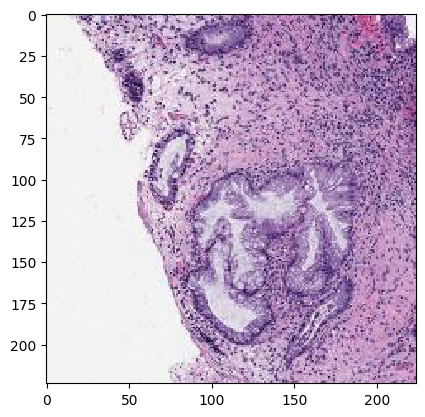

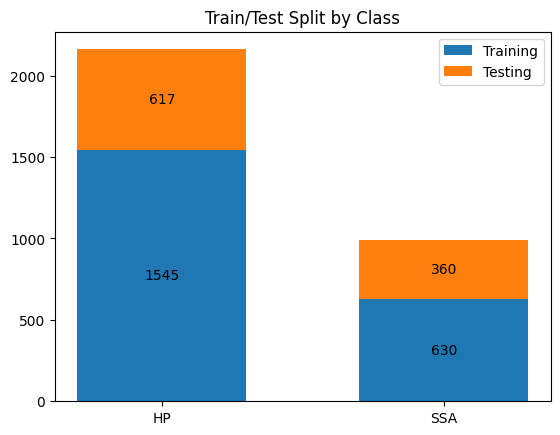

In [ ]:
### Plotting Dataset Statistics
# Plotting an example image
plt.imshow(x_train[0], interpolation='nearest')
plt.show()

classes = ('HP', 'SSA')
train_test_counts = {
    'Training': np.array([len(y_train_one_hot[y_train_one_hot[:,0] == 1]),len(y_train_one_hot[y_train_one_hot[:,0] == 0])]),
    'Testing': np.array([len(y_test_one_hot[y_test_one_hot[:,0] == 1]),len(y_test_one_hot[y_test_one_hot[:,0] == 0])])
}
width = 0.6
fig, ax = plt.subplots()
bottom = np.zeros(2)

for dataset, class_count in train_test_counts.items():
  p = ax.bar(classes, class_count, width, label=dataset, bottom=bottom)
  bottom+=class_count

  ax.bar_label(p, label_type='center')

ax.set_title('Train/Test Split by Class')
ax.legend()
plt.show()

### Final Dataset Alterations
The last three things we need to do is shuffle the training dataset, create a validation set, and augment the training set.

Shuffling is a critical step in machine learning as models can learn unintentional patterns in the dataset itself if similar data is grouped together. This is undesirable as in a testing situation, the data is unlikely to be grouped so nicely. This can be done in tandom with the second step.

Next, we must create a validation set. This can be done using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method.

We also need to augment the dataset for this specific example. This is a tricky dataset for a CNN learner, and so we need to augment the data a little. This means rotating, zooming in on, and translating random images in random ways to ensure the model is learning what we actually intend it to. Keras has a [handy tool](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for this job. I have included an example with my recommended settings below.

In [ ]:
# include train_test_split functions here!

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test_one_hot, test_size=0.5,shuffle=True, random_state=42)


aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

# Now fit the augmentation to the training data!

### The Fun Part - Building a Model
You have some freedom here to create a model however you like, but this step does matter. Simply throwing the MNIST example network here and letting it run will not perform up to par.

Heres some tips:
* **Overfitting will be your biggest hurdle in this project**. This dataset is extremely prone to overfitting, where the model just memorizes training data.
 - Most of these hints focus on how to limit overfitting. This problem is why our validation set is so important. As the model trains, you will see the training metrics (loss, accuracy, etc.) and the validation metrics (val_loss, val_accuracy, etc.). If your training metrics are improving (**loss decreasing and accuracy increasing is good**) while your validation metrics are getting worse, likely you are overfitting.
 - If the training and validation metrics are both getting worse, your model is underfitting (not learning the data well), meaning the model needs to be more complex. **It is normal for this to happen in the first 10 or so epochs**. Dropout layers may also cause short periods of underfitting, which is normal.

* **Increasing the number of filters increases the number of features the model can store**. It's tempting to throw as many filters as you can at the problem, but in this case, less will be more up to a point. Experiment with different values between 16 and 128. Try powers of 2 until you find something that works. Too many filters and your model won't fit in memory, so decrease the image resolution to accomodate.

* **Increasing the number of hidden layers is another way to increase the complexity of the model and store more features**. Overly complex models can overfit more easily, so beware of adding unneeded layers.

* While controling complexity can help overfitting, you will likely find it's not enough. **Research regularization, dropout, batch normalization, and max pooling** if things aren't working. If you use regularization, I suggest L1L2 with values of 1e-5 or less. If you use dropout, the standard is 0.5 for each layer and 0.2 at the output.

* Your output layer should be a Dense layer with one neuron for each class. In the MNIST example, we had output_layer = tf.keras.layers.Dense(10, activation="softmax"), with 10 being the number of classes. We do not have 10 here. You will use [softmax](https://en.wikipedia.org/wiki/Softmax_function) for this final activation and [relu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) elsewhere.

In [ ]:
from tensorflow.keras import models, layers

image_height = image_width = 224
num_channels = 3

from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

# Dense (fully connected) layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout for regularization

model.add(layers.Dense(2, activation='softmax'))

### Training the Model
As we discussed in class, this same basic structure can be used for training just about any supervised neural network type, regardless of architecture. A few alterations have been made:

*   The functions recall_m, precision_m, and f1_m have been included. These functions calculate the metrics for recall, precision, and f1-measure during training - [learn more](https://www.learndatasci.com/glossary/precision-and-recall/). These metrics all give a different idea of how well the model is actually representing the data. Each ranges from 0 to 1 with 0 being the worst and 1 being perfect.
 - Recall from lecture what happens to accuracy if a class is unbalanced. If 70% of the input is negative, what would be the accuracy of always guessing 0? Is that useful?
 - Notice also that the callback function now monitors validation f1-measure. Why might this be better than monitoring accuracy? Would validation loss be a good metric instead?
*   The number of epochs has increased and batch size has decreased. The more complex model needs more training time. Larger batch sizes are harder to fit in memory, so for this bigger model it is decreased.
* The data is input using aug.flow(). This method applies the random alteration of data as it trains, helping the model learn the complex dataset.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Assuming y_train is a numpy array with binary labels (0s and 1s)
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = {}

print('Weights for each class:')
for i in range(num_classes):
    class_weights[i] = total_samples / (num_classes * class_counts[i])
    print("{}: {:.4f}".format(i, class_weights[i]))

Weights for each class:
0: 0.7039
1: 1.7262


In [ ]:
# %%
### Train the model
import keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Train the model

# Final model characteristics - callback monitors if we stop making progress and ends early
callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=50, restore_best_weights=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy", f1_m],
)

# How many datapoints to run through at once, smaller is memory efficient, but more erratic
batch_size = 32
# How many times to run training data through maximum
epochs = 100



y_train_one_hot = np.array(y_train_one_hot)


# Model training
with tf.device('/GPU:0'):
    history = model.fit(aug.flow(x_train,
            y_train_one_hot,
            batch_size=batch_size),
            epochs = epochs,
            verbose = 1,
            callbacks = [callback],
            validation_data = (x_val, y_val),
            class_weight = class_weights # This will almost definitely be worth implementing
            )

Shape of x_train: (2175, 224, 224, 3)
Shape of y_train_one_hot: (2175, 2)
1/1 [==============================] - 0s 70ms/step
Shape of model output: (1, 2)
Epoch 1/100
68/68 [==============================] - 28s 389ms/step - loss: 0.7158 - accuracy: 0.5361 - f1_m: 0.5360 - val_loss: 0.6820 - val_accuracy: 0.6086 - val_f1_m: 0.6152
Epoch 2/100
68/68 [==============================] - 25s 371ms/step - loss: 0.6948 - accuracy: 0.5674 - f1_m: 0.5674 - val_loss: 0.6861 - val_accuracy: 0.5922 - val_f1_m: 0.5937
Epoch 3/100
68/68 [==============================] - 26s 384ms/step - loss: 0.6904 - accuracy: 0.4749 - f1_m: 0.4749 - val_loss: 0.6889 - val_accuracy: 0.5656 - val_f1_m: 0.5566
Epoch 4/100
68/68 [==============================] - 25s 369ms/step - loss: 0.6861 - accuracy: 0.5186 - f1_m: 0.5187 - val_loss: 0.6559 - val_accuracy: 0.6045 - val_f1_m: 0.6055
Epoch 5/100
68/68 [==============================] - 27s 392ms/step - loss: 0.6781 - accuracy: 0.5536 - f1_m: 0.5536 - val_loss: 0.6

"\nwith tf.device('/GPU:0'):\n    history = model.fit(\n            # Input Data\n            x_train,\n            y_train,\n\n            # Parameters\n            batch_size=batch_size,\n            epochs = epochs,\n            verbose = 1,\n            callbacks = [callback],\n            class_weight = class_weight,\n            # Splits train data into train/test data to limit overfitting\n            validation_split = 0.2\n            )\n\n"

### Model Evaluation
The next two cells contain some code to evaluate your model. The first of the two plots the loss of your model as it trained. You would ideally see a smooth, consistently downwards curve for both values, but noise may make the training more erratic.

The second cell will generate the metrics for your testing data. These are the values that truly matter and tell you how well the model learned the overall dataset.

The confusion matrix may be particularly interesting as it gives you the classes and tells you what the model is consistently missing

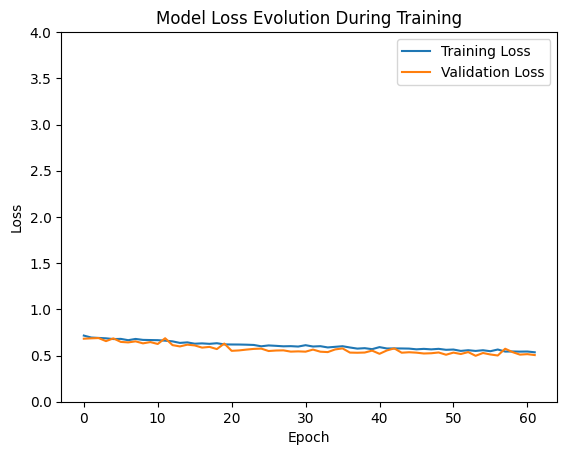

In [ ]:
### Model Training Metrics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 4)
plt.title('Model Loss Evolution During Training')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

16/16 [==============================] - 0s 21ms/step
Accuracy = 0.5030674846625767
Recall = 0.8698224852071006
Precision = 0.39945652173913043
F1-Measure = 0.2737430167597765


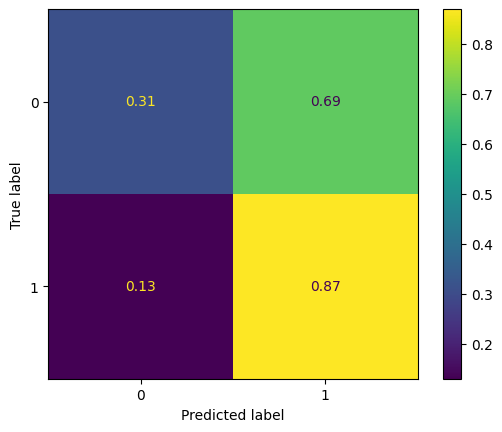

In [ ]:
### Evaluate on Training Data

# Get the model's predictions on the testing data
preds = model.predict(x_test)

correct = 0
pred_binary = []
y_binary = []
for i,sol in enumerate(y_test):
  if np.argmax(sol) == np.argmax(preds[i]):
    correct +=1
  pred_binary.append(np.argmax(preds[i]))
  y_binary.append(np.argmax(sol))

print("Accuracy = " + str(correct / len(preds)))

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_binary, pred_binary, normalize='true')

from sklearn.metrics import confusion_matrix
upper, lower = confusion_matrix(y_binary, pred_binary)
tn = upper[0]
fp = upper[1]
fn = lower[0]
tp = lower[1]

recall = tp / (tp + fn)
precision = tp / (tp + fp)
print("Recall = " + str(tp / (tp + fn)))
print("Precision = " + str(tp / (tp + fp)))
print("F1-Measure = " + str((recall * precision) / (recall + precision)))

## Final Questions
Answer in-line or on a separate document.
1. Assuming you didn't get 100% accuracy, what are 2 reasons your model didn't perform better? If you did get 100% accuracy, how did you do it, that's insane! Please answer in 2-4 sentences for each.

2. What was the hardest part of the process? What was the easiest? Please answer in 1-3 sentences for each question.

1. It unsurprisingly was not at 100% accuracy. I presume this is the case for two reasons: *(1) Simple model architecture:* High accuracy models would be more complex and be capable of more intensive calculations. *(2) Not an ideal dataset:* More data in terms of quality (less imbalance between the two classes, more information regarding the samples, etc) and quantity (more samples) is probably going to yield better results with a similar architecture.

2. The hardest part of the process was trying to tune the parameters to optimize the outcome of the ML model. I also kept maxing out my GPU limits, so it was a longer process than expected. The easiest part was probably acquiring resources to understand how to build and implement the model. The lecture and the internet proved to be very helpful in creating a  framework and solve any problems I encountered on the way.